# Investigations

The relevant data structures will be saved in a dictionary and pickled for easy access.

## A. Pressure
### 1. Lateral resolution- 

Maximum Pressure
* Here we can take the maximum of pressure values over time.
* Disadvantage of this method is that it compresses the information in the time domain. Should only give information about the lateral resolution, not the axial resolution.
* We can also call this the 'tightness of focus.'

Root Mean Squared Pressure
* Similar analysis for lateral resolution

### 2. Beam profile-
Maximum pressure
* Use angular variation

### 3. Beam shearing- Wave shape cross correlation
This would allow us to assess where the ideal wave is most similar to the phase-wrapped one.

### 4. Degradation- Similarity over time 
We can use the Euclidean distance to assess similarity

## B. Intensity through a plane
We can also plot the intensity over time

### 1. Lateral resolution

### 1. Axial resolution- Intensity over time at the focus

### 2. Beam profile- Peak intensity at different depths

In [2]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np

from scipy.signal import correlate
from operator import itemgetter


In [371]:
from preprocess import import_mat

date = '0309'
mode = 'focus'
angle = '30'
extension = date + '_' + mode + '_' + angle
extension = '0309_focus_30'

path = '../raw_data/'

def genpath(date, mode, angle):
    extension = date + '_' +mode + '_' + angle
    return path + extension
# The length of array X depends on how many sensor variables are measured
X = import_mat(path + extension)


In [ ]:
genpath

In [358]:
packet = {}

In [24]:
x = 100e-3
PML_X_SIZE = 20            # [grid points]
Nx = 256 - 2*PML_X_SIZE    # [grid points]

dx = x/ Nx
r = 25e-3/dx
print(r)

x_len, y_len, t_len = np.shape(X[0])

54.0


In [359]:
# Get average pressure over time, maximum and root mean squared
pressure_max = np.max(X[0], axis=2)
pressure_rms = np.sqrt(np.average(X[0]*X[0], axis=2))

packet['p_max'] = pressure_max
packet['p_rms'] = pressure_rms

(<matplotlib.image.AxesImage at 0x7f95ec9c5490>,
 <matplotlib.image.AxesImage at 0x7f95dadc75b0>)

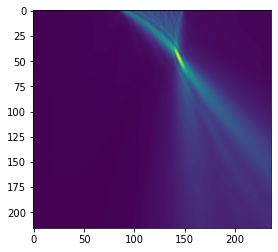

In [366]:
plt.imshow(pressure_max), plt.imshow(pressure_rms)

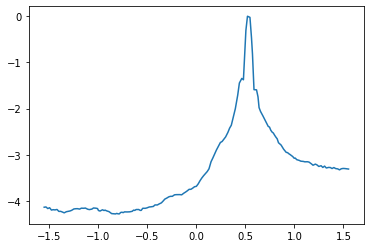

In [361]:
# Obtain beam profile based on the focus distance
values = []
for i in range(x_len):
    for j in range(y_len):
        centered = j- y_len/2 + 1
        radius = round(np.sqrt((centered)**2 + i**2))

        if (radius == r) and i > 0: 
            angle = np.arctan((centered) / i )
            values.append([angle, pressure_max[i,j]])

# Sort values based on the angles
values = sorted(values, key=itemgetter(0))

a, p = np.array(values).T
plt.plot(a,np.log(p/max(p)))
packet['beam_profile'] = np.array(values).T

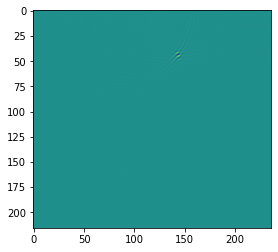

In [363]:
# Find time point with highest pressure, which should be the focus
t_foc = np.unravel_index(np.argmax(X[0]), X[0].shape)[2]
array = X[0, :,:,t_foc]
plt.imshow(array, vmin=-np.max(array), vmax= np.max(array))
packet['p_foc'] = array

In [320]:
t_foc = np.unravel_index(np.argmax(X[0]), X[0].shape)[2]
intensity = X[1:]
int_foc = X[1:,:,:,t_foc]

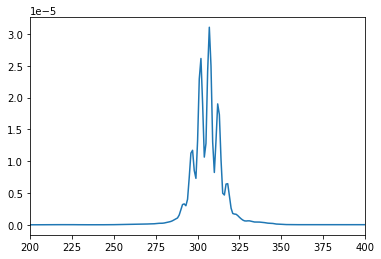

In [365]:
# Obtain list of Cartesian locations with exact radius to mask
mask_list = []
for i in range(x_len):
    for j in range(y_len):
        centered = j- y_len/2 + 1
        radius = round(np.sqrt((centered)**2 + i**2))
        if (radius == r) and i > 0: 
            angle = np.arctan((centered) / i)
            mask_list.append([i,j,angle])

# Obtain intensity through a plane at a certain distance
intensities = []
for t in range(t_len): 
    temp = []
    for item in mask_list:
        i,j,angle = item[0],item[1],item[2]
        temp.append(intensity[0, i,j,t]*np.cos(angle) + intensity[1, i,j, t]*np.sin(angle))
    intensities.append(np.sum(temp))

plt.plot(intensities)
plt.xlim(200,400)
packet['intensity_time'] = intensities

In [396]:
def extract(fpath):
    X = import_mat(fpath)

    packet = {}
    # Get average pressure over time, maximum and root mean squared
    pressure_max = np.max(X[0], axis=2)
    pressure_rms = np.sqrt(np.average(X[0]*X[0], axis=2))

    packet['p_max'] = pressure_max
    packet['p_rms'] = pressure_rms

    # Obtain beam profile based on the focus distance
    values = []
    for i in range(x_len):
        for j in range(y_len):
            centered = j- y_len/2 + 1
            radius = round(np.sqrt((centered)**2 + i**2))

            if (radius == r) and i > 0: 
                angle = np.arctan((centered) / i )
                values.append([angle, pressure_max[i,j]])

    #######
    # Sort values based on the angles
    values = sorted(values, key=itemgetter(0))

    a, p = np.array(values).T
    packet['beam_profile'] = np.array(values).T

    #######
    # Find time point with highest pressure, which should be the focus
    t_foc = np.unravel_index(np.argmax(X[0]), X[0].shape)[2]
    array = X[0, :,:,t_foc]
    #plt.imshow(array, vmin=-np.max(array), vmax= np.max(array))
    packet['p_foc'] = array

    #######
    # Obtain list of Cartesian locations with exact radius to mask
    mask_list = []
    for i in range(x_len):
        for j in range(y_len):
            centered = j- y_len/2 + 1
            radius = round(np.sqrt((centered)**2 + i**2))
            if (radius == r) and i > 0: 
                angle = np.arctan((centered) / i)
                mask_list.append([i,j,angle])

    #######
    # Obtain intensity through a plane at a certain distance
    intensities = []
    intensity = X[1:]
    for t in range(t_len): 
        temp = []
        for item in mask_list:
            i,j,angle = item[0],item[1],item[2]
            temp.append(intensity[0, i,j,t]*np.cos(angle) + intensity[1, i,j, t]*np.sin(angle))
        intensities.append(np.sum(temp))
    packet['intensity_time'] = intensities
    return packet

angle = '15'

for angle in ['35', '40']:
    fpath = genpath(date, 'focus_wrap', angle)
    wrapped = extract(fpath)

    fpath = genpath(date, 'focus', angle)
    unwrapped = extract(fpath)

    import pickle

    data = {'unwrapped':unwrapped, 'wrapped': wrapped}

    with open('../processed_data/'+date + '_' + angle, 'wb') as f:
        pickle.dump(data, f)

xs = np.arange(0, x_len)
ys = np.arange(-y_len/2 +1, y_len/2+1)
Xs, Ys = np.meshgrid(xs, ys)

mask = np.round(np.sqrt(Xs**2 + Ys**2)) == r 
intensity[:,mask.T,:]